## Imports

In [1]:
import torch
import torchvision

from torch.utils.data import DataLoader, Dataset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os



In [2]:
## Setting torch seed

random_seed = 1
torch.manual_seed(random_seed)

## Data Loaders and MINST DataSet

In [3]:
#Loaders Parameters
batch_size_train = 64
batch_size_test = 1000

path = "/home/franio/Desktop/handwritten-digits-recognizer/"


train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(path, train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(path, train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)


### Examples

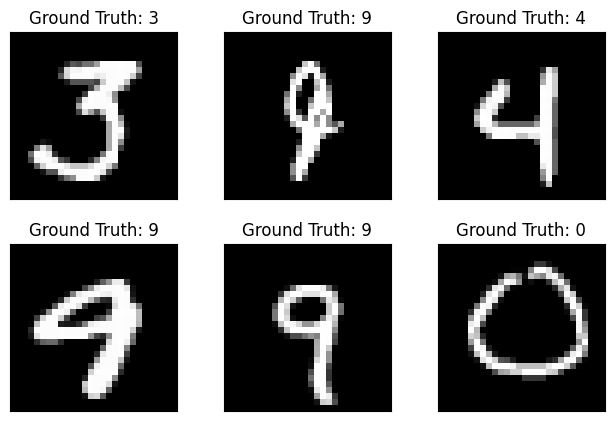

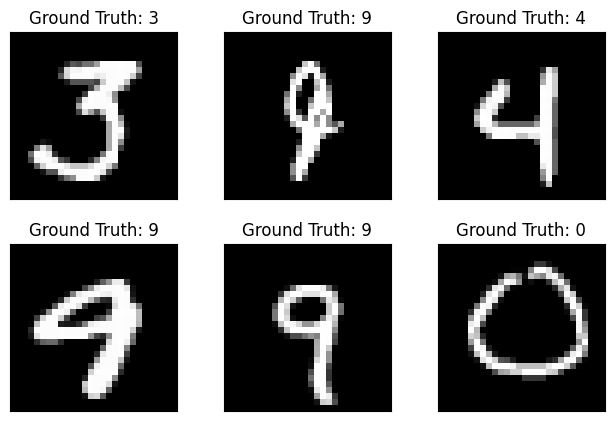

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

## Model Architecture

In [5]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Training the model

=========== Epoch 1 ===========
=========== Epoch 2 ===========
=========== Epoch 3 ===========


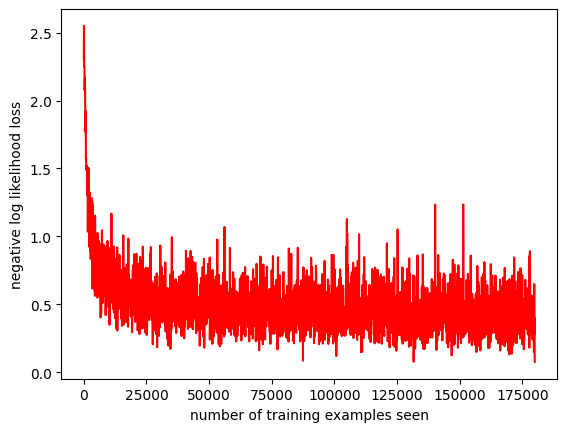

In [6]:



#Hyperparameters
n_epochs = 3
learning_rate = 0.01

model = MyModel()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()


train_losses = []
train_counter = []

for epoch in range(n_epochs):
    model.train()
    print(f"=========== Epoch {epoch + 1} ===========")
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output, target)
        train_losses.append(loss.item())
        train_counter.append((batch_idx*64) + ((epoch)*len(train_loader.dataset)))

        loss.backward()
        optimizer.step()


plt.plot(train_counter, train_losses, color='red')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

## Saving a model


In [9]:
torch.save(model.state_dict(), "model.pth")

## Testing a model



Test set: Avg. loss: 0.0001, Accuracy: 9675/10000 (97%)



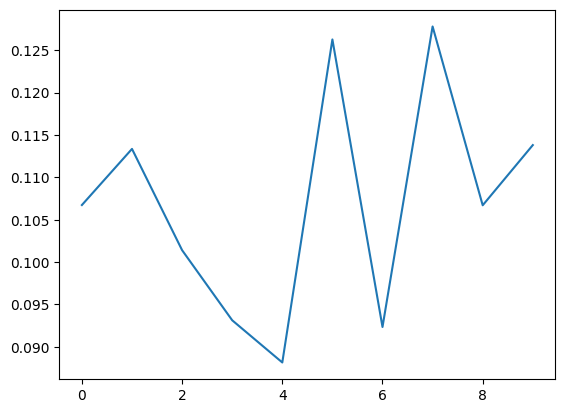

In [8]:
test_losses = []

test_loss = 0
correct = 0

model.eval()
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        
        test_loss += criterion(output, target).item()
        pred = output.data.max(1, keepdim=True)[1]
        
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        test_losses.append(criterion(output, target).item())
        
    test_loss /= len(test_loader.dataset)
    
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


counter = np.arange(len(test_losses))
plt.plot(counter, test_losses)
plt.show()